In [1]:
import tensorflow as tf
import numpy as np
import torch

In [19]:
from urllib.request import urlretrieve
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
urlretrieve(url, './2021_BOAZ_STUDY_WINTER/WEEK04/credit_card.xls')


('./2021_BOAZ_STUDY_WINTER/WEEK04/credit_card.xls',
 <http.client.HTTPMessage at 0x1bb3b5b9488>)

- 이번 PCA 실습에서 사용하고자 하는데이터는 Machine Learning Repository에서 다운을 받을 수 있는 데이터로, 내가 처음에 생각한 대로 csv파일이 아닌 xls(엑셀)파일이었다.
- python으로 인터넷의 데이터를 현재 저장소로 저장하는 urllib.request 클래스의 urlretrieve를 사용하고 현재 directory로 저장을 해 주는 것이 가능하다.
- 이제 이 데이터를 pandas dataframe으로 저장해 보자

In [20]:
import pandas as pd
df = pd.read_excel('C:\\Users\\이지혜\\2021_BOAZ_STUDY_WINTER\\WEEK04\\credit_card.xls', header = 1, sheet_name = 'Data').iloc[0:, 1:]
print(df.shape)
df.head(3)

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [18]:
pip install xlrd
# pd.read_excel() 기능이 작동하지 않아서 exel파일을 읽을 수 있는(dataframe으로 바꾸어 주는) xlrd를 깔아주니 데이터가 읽혔다.

Note: you may need to restart the kernel to use updated packages.


In [23]:
# df의 'default' 칼럼의 데이터를 target, 즉 y data로 이용할 것이기 떄문에 따로 y_target으로 바꾸어 준 뒤에 실제 dataframe에서 drop을 진행해 준다.
df.rename(columns = {'PAY_0':'PAY_1', 'default payment next month' : 'default'}, inplace = True)
y_target = df['default']
x_features = df.drop('default', axis = 1)

<AxesSubplot:>

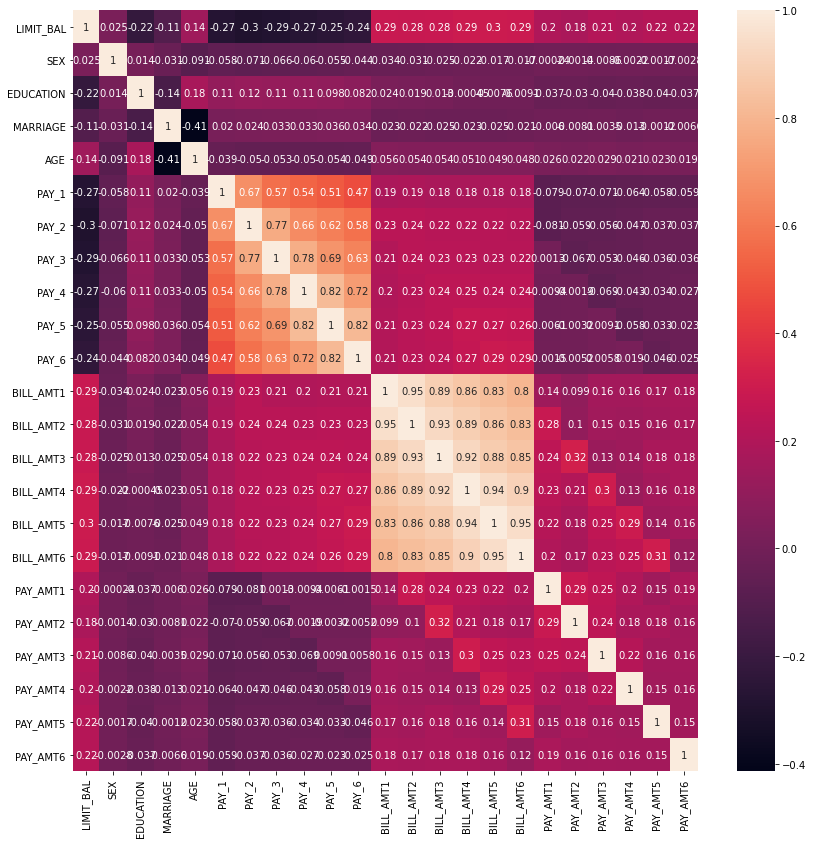

In [24]:
# PCA를 진행하는 것은 데이터의 분산, 즉 변동성을 기준으로 각 데이터가 기준에 대해서 가장 잘 구분이 될 수 있도록
# 변동성이 최대가 되는 축을 찾아서 주성분으로 정하게 된다.
# 그렇기 때문에 차원 축소를 진행할 때에 불필요한 기준의 차원을 줄여 나가는 것이 중요하고, 때문에 각 속성끼리의 상관도를 확인하는 것은 중요하다.

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = x_features.corr()
plt.figure(figsize = (14,14))
sns.heatmap(corr, annot = True)

In [26]:
# 서로 높은 상관도를 갖는 속성들은 소수의 PCA만으로도 자연스럽게 속성들의 변동성을 수용할 수 있다.
# 따라서 상관도가 제일 높은 6개의 속성인 BILL_AMT1 부터 BILL_AMT6의 6개의 속성을 이용해서 PCA변환을 진행하고자 한다.

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 상관도가 높은 속성명 저장
cols_bill = ['BILL_AMT'+str(i) for i in range(1, 7)]

scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(x_features[cols_bill])
pca = PCA(n_components = 2) # 6차원 -> 2차원으로 축소
pca.fit(df_cols_scaled)

# 2차원, 즉 2개의 축으로 데이터를 사영시켜준 결과인데, 첫번째 축의 기준으로 90%넘게 예측의 정확도가 나오는 것으로 보아
# 변동성을 2개의 차원만으로도 잘 반영할 수 있음을 확인이 가능하다.
print('PCA 속성 별 변동성 : ',pca.explained_variance_ratio_)

PCA 속성 별 변동성 :  [0.90555253 0.0509867 ]


In [29]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

RFC = RandomForestClassifier(n_estimators = 300, random_state = 156)

# 먼저 그냥 전체 데이터를 이용해서 예측의 정확도를 3차 교차 검증을 통해서 진행한다.
scores = cross_val_score(RFC, x_features, y_target, scoring = 'accuracy', cv = 3)

print('CV = 3인 경우에개별 fold set별 점수', scores)
print('평균 Accuracy : {0:.4f}'.format(np.mean(scores)))

CV = 3인 경우에개별 fold set별 점수 [0.8083 0.8196 0.8232]
평균 Accuracy : 0.8170


In [30]:
scaler = StandardScaler()

# 우리가 변동성이 높을 것으로 생각한 6개의 속성에 대해서 추출한 x데이터인 df_scaled를 이용해서 2차원으로 사영한다.
df_scaled = scaler.fit_transform(x_features)
pca = PCA(n_components = 6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(RFC, df_pca, y_target, scoring = 'accuracy', cv = 3)

print('평균 Accuracy : {0:.4f}'.format(np.mean(scores_pca)))

평균 Accuracy : 0.7971


** PCA는 차원 축소를 통해 데이터를 쉽게 인지하는데 활용할 수 있지만, 이보다 더 활발하게 적용되는 영역은 컴퓨터 비전 분야이다. 특히 얼굴 인식의 경우에는 Eigen-Face라고 불리는 PCA 변환으로 원본 얼굴 이미지를 변환해서 사용한다.**

### SVD(Singular Value Decomposition)

In [32]:
import numpy as np
from numpy.linalg import svd

np.random.seed(121)
a = np.random.randn(4, 4)
print(np.round(a, 4))

[[-0.212  -0.2849 -0.5739 -0.4403]
 [-0.3301  1.1837  1.6154  0.3671]
 [-0.0141  0.6296  1.7096 -1.327 ]
 [ 0.4019 -0.1914  1.4038 -1.9688]]


In [39]:
U, Sigma, VTraverse = svd(a)
# Sigma Matrix의 경우에는 행렬의 대각에 위치한 값 뿐만 아니라 그렇지 않은 경우도 모두 0이기 때문에 0이 아닌 값의 경우만 1차원의 행렬로 표현을 한다.
print('U Matrix : \n{}'.format(U)), print('Sigma : \n{}'.format(Sigma)), print('T_t Matrix : \n{}'.format(VTraverse))

U Matrix : 
[[-0.07913928 -0.31822729  0.86653217  0.37628494]
 [ 0.38294523  0.78655287  0.12002097  0.46934262]
 [ 0.65640669  0.02243181  0.35668848 -0.66437971]
 [ 0.64515128 -0.52873697 -0.32785711  0.44353889]]
Sigma : 
[3.4229581  2.02287339 0.46263157 0.07935069]
T_t Matrix : 
[[ 0.04100747  0.22367823  0.78643002 -0.57429458]
 [-0.20019867  0.56209596  0.37041464  0.71187191]
 [-0.77847455  0.3945136  -0.33259252 -0.3573774 ]
 [-0.5934781  -0.69164673  0.36565426  0.18895901]]


(None, None, None)

In [40]:
# Sigma를 다시 0을 포함한 대칭 행렬로 바꾸어 주고 U, Sigma, VTraverse의 행렬 3개를 모두 내적하면 처음에 random 하게 만들었던 a matrix로 다시 돌아가게 될 것이다.
Sigma_mat = np.diag(Sigma)
a_ = np.dot(np.dot(U, Sigma_mat), VTraverse)

In [41]:
print(np.round(a_, 3))
# np.round(array, int)는 그냥 단순히 소수점 아래 출력 자리수를 정해주는 것임(반올림)

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


Text(0, 0.5, 'TruncatedSVD Component 2')

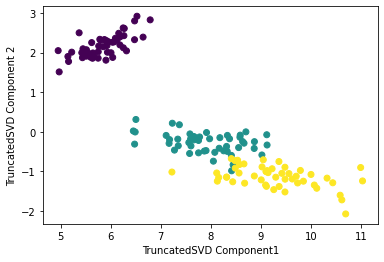

In [44]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
iris_ftrs = iris.data
tsvd = TruncatedSVD(n_components = 2)
tsvd.fit(iris_ftrs)
iris_tsvd = tsvd.transform(iris_ftrs)

plt.scatter(x = iris_tsvd[:, 0], y = iris_tsvd[:, 1], c = iris.target)
plt.xlabel('TruncatedSVD Component1')
plt.ylabel('TruncatedSVD Component 2')

#### SVD vs PCA
1. 만약에 데이터를 Standard Scaler을 이용해서 표준 정규분포의 형태로 바꾸어준다면 SVD와 PCA를 통해 추출한 변환이 동일함을 확인할 수 있다.
    - 이는 scaling을 적용한 데이터의 경우 데이터의 중심이 동일해지기 때문이다.  
    
2. 또한 PCA는 SVD알고리즘을 이용해서 구현이 되었음을 알 수 있다.  

**3. 그러나 PCA는 밀집 행렬(Dense Matrix)에 대한 변환만 가능한 반면 SVD의 경우에는 희소 행렬(Sparse Matrix)에 대한 변환도 가능하다.**   
### -> 이유는??

4. SVD는 PCA와 유사하게 Computer Vision 영역에서 이미지 압축을 통한 패턴 인식과 신호 처리 분야에 사용이 된다.
    - 또한 text의 topic Modeling기법인 LSA(Latent Semantic Analysis)의 기반 알고리즘이다.

### NMF (Non-Negative Matrix Factoralization)

C:\CONDA\envs\final\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\CONDA\envs\final\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Text(0, 0.5, 'NMF Component2')

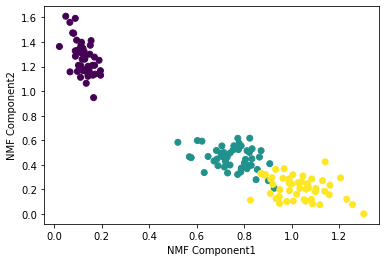

In [45]:
from sklearn.decomposition import NMF
from sklearn.datasets import load_iris

iris = load_iris()
iris_features = iris.data
nmf = NMF(n_components = 2) # 2차원의 데이터로 차원 축소를 진행하겠단 의미
nmf.fit(iris_features)
iris_nmf = nmf.fit_transform(iris_features)

plt.scatter(x = iris_nmf[:, 0], y = iris_nmf[:, 1], c = iris.target)
plt.xlabel('NMF Component1')
plt.ylabel('NMF Component2')